In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import SCCircuit
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
import os

['/Users/sbittner/Documents/dsn/dsn/models/SCCircuit/SCCircuit_sW_P_sW_A_vW_PA_vW_AP_dW_PA_dW_AP_hW_P_hW_A_inforoute_mu=5.00E-02_0.00E+00_2.00E-01_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=3.00_c=3_rs=1/opt_info.npz', '/Users/sbittner/Documents/dsn/dsn/models/SCCircuit/SCCircuit_sW_P_sW_A_vW_PA_vW_AP_dW_PA_dW_AP_hW_P_hW_A_inforoute_mu=5.00E-02_0.00E+00_2.00E-01_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=3.00_c=3_rs=2/opt_info.npz', '/Users/sbittner/Documents/dsn/dsn/models/SCCircuit/SCCircuit_sW_P_sW_A_vW_PA_vW_AP_dW_PA_dW_AP_hW_P_hW_A_inforoute_mu=5.00E-02_0.00E+00_2.00E-01_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_0.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=3.00_c=3_rs=3/opt_info.npz', '/Users/sbittner/Documents/dsn/dsn/models/SCCircuit/SCCircuit_sW_P

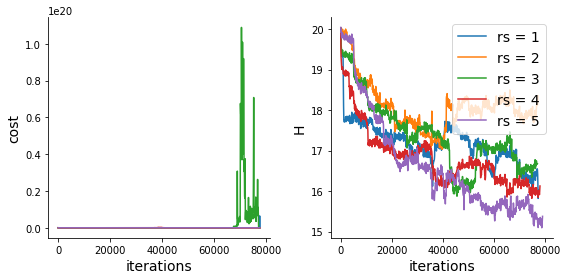

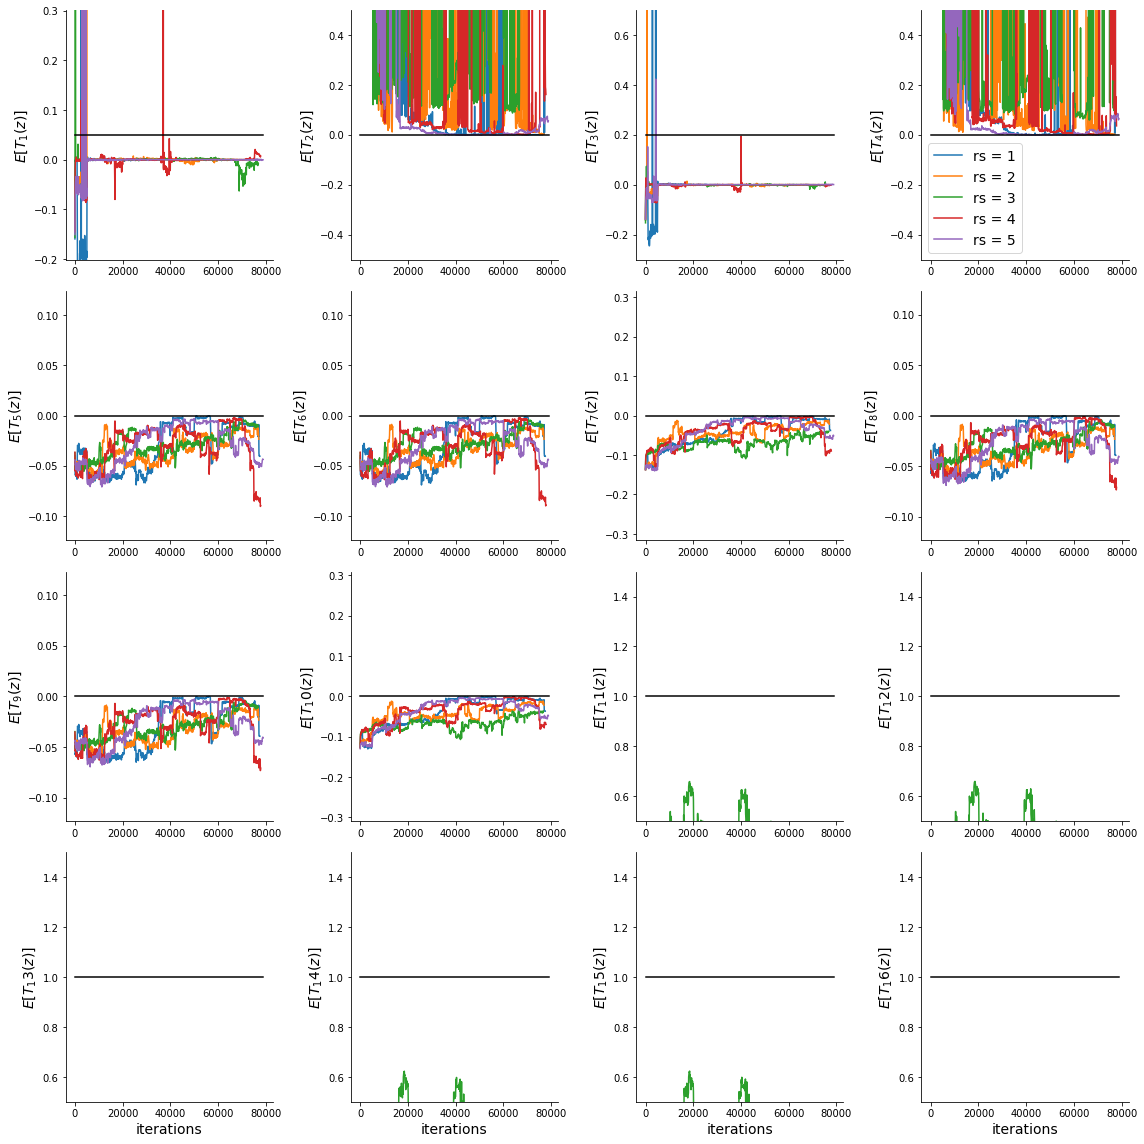

p values
0
1
2
3
4


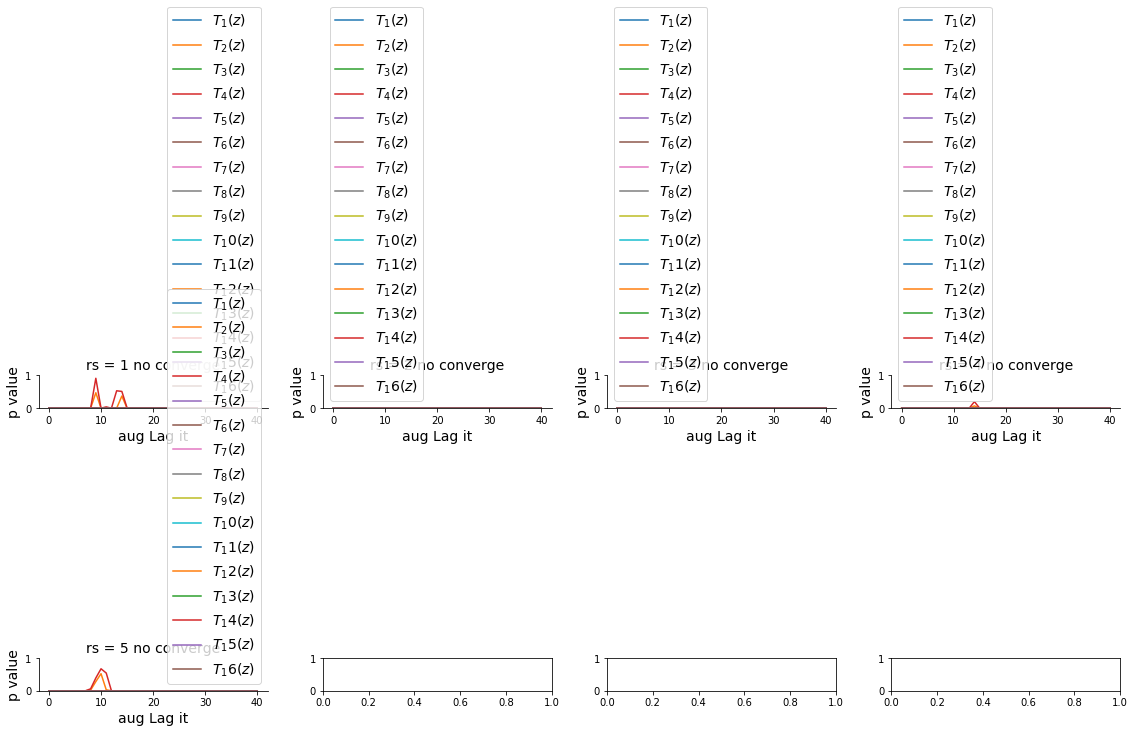

In [7]:
EPS = 1e-16

# multivariate normal initialization variance
sigma_init = 3.0
c_init_order = 3

dirstr = 'SCCircuit'

# create an instance of the V1_circuit system class
fixed_params = {'E_constant':0.0, \
                'E_Pbias':0.1, \
                'E_Prule':0.5, \
                'E_Arule':0.5, \
                'E_choice':-0.2, \
                'E_light':0.1};

C = 4
p_NI = 0.8
p_DI = 0.6

err_inc_P = 0.05
err_inc_A = 0.2

behavior_type = "inforoute"

C = 6

if (C==2):
    p_NI = 0.8
    p_DI = 0.6
    behavior_type = "inforoute"
    means = np.array([p_NI, p_DI, 0.0, 0.0, 1.0, 1.0])
elif (C==4):
    err_inc_P = 0.05
    err_inc_A = 0.2
    behavior_type = "inforoute"
    means = np.array([err_inc_P, err_inc_A, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])
elif (C==6):
    err_inc_P_DI = 0.05
    err_inc_A_DI = 0.2
    err_inc_P_CI = 0.0
    err_inc_A_CI = 0.0
    behavior_type = "inforoute"
    means = np.array([err_inc_P_DI, err_inc_P_CI, err_inc_A_DI, err_inc_A_CI, \
                      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                      1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    
behavior = {
    "type": behavior_type,
    "means": means,
}

model_opts = {'params':'full', 'C':C}

system = SCCircuit(fixed_params, behavior, model_opts=model_opts)

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'K': 1, \
             'D':system.D, \
             'post_affine':True, \
             'flow_type':flow_type, \
             'repeats':nlayers};
lr_order = -3

start_rs = 1
num_rs = 5
random_seeds = np.arange(start_rs, num_rs+start_rs)

basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
AL_final_its = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    if (os.path.isfile(fname)):
        try:
            npzfile = np.load(fname)
        except:
            print('except')
            continue
        fnames.append(dsndir + 'opt_info.npz')
        legendstrs.append('rs = %d' % random_seed)
        behavior_i = npzfile['behavior'][()]
        cs_i = npzfile['cs']
        k_max = len(cs_i)
    else:
        print('no fname', fname)
        continue
    #AL_final_its.append(k_max-1)
    
frac_samps = 0.5
print(fnames)

figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, con_method='2', maxconlim=0.5)

In [5]:
#pfnames = ['images/Z_SC_pvar_%s_c=%d_p=%d_rs=%d.png' % (model_opts["params"], c_init_order, int(100*p), rs) \
#           for rs in range(start_rs, start_rs+num_rs)]

Zs = dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=legendstrs, AL_final_its=AL_final_its, \
              fontsize=14, ellipses=False, tri=True) #3, pfnames=pfnames)


rs = 1 has not converged so not plotting.
rs = 2 has not converged so not plotting.
rs = 3 has not converged so not plotting.
rs = 4 has not converged so not plotting.
rs = 5 has not converged so not plotting.


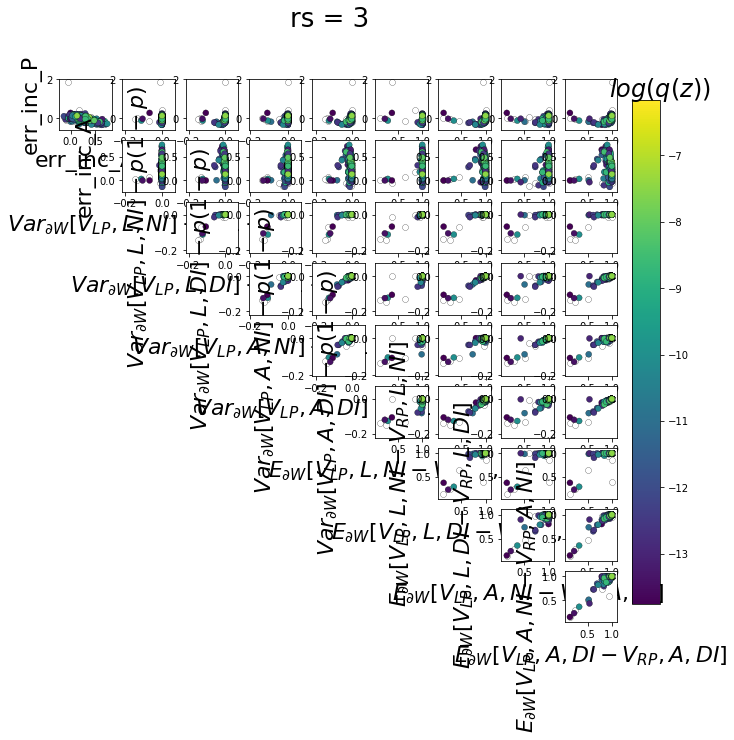

In [43]:
#pfnames = ['images/T_x_SC_pvar_%s_c=%d_p=%d_rs=%d.png' % (model_opts["params"], c_init_order, int(100*p), rs) \
#           for rs in range(start_rs, start_rs+num_rs)]
T_xs = dsn_pairplots(fnames, 'T_xs', system, system.num_suff_stats, f_str='identity', \
              c_str='log_q_z', legendstrs=legendstrs, AL_final_its=AL_final_its, \
              fontsize=22, ellipses=False, tri=True) #, pfnames=pfnames)        



(41, 1000, 2)
0 num approx zero 973


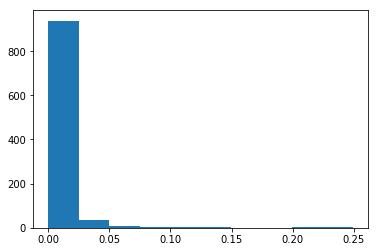

1 num approx zero 122


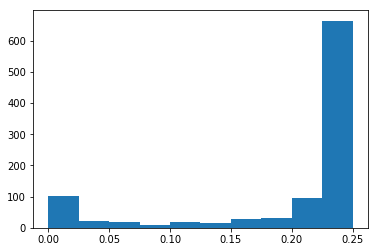

2 num approx zero 6


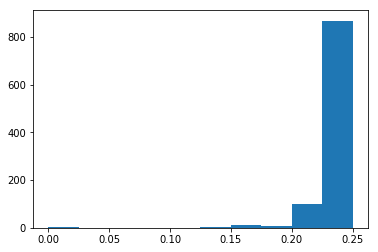

3 num approx zero 2


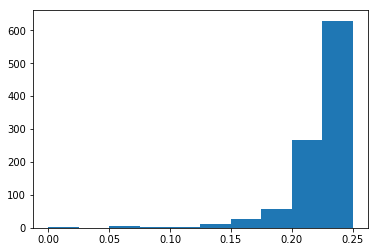

4 num approx zero 1


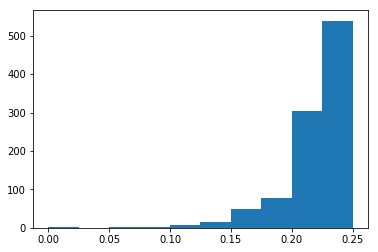

5 num approx zero 0


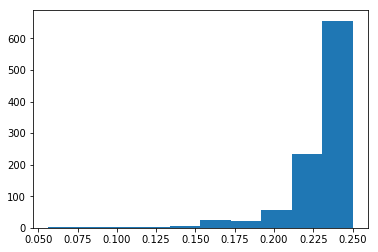

6 num approx zero 0


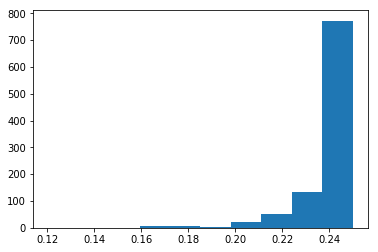

7 num approx zero 16


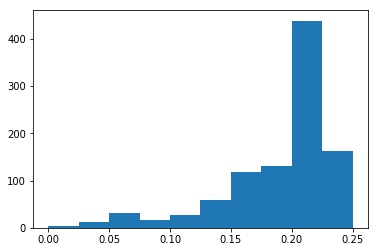

8 num approx zero 2


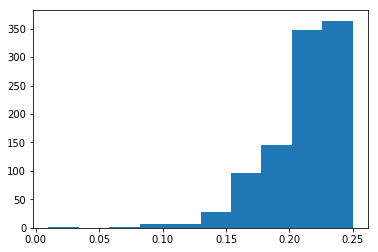

9 num approx zero 0


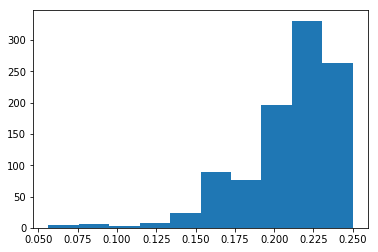

10 num approx zero 0


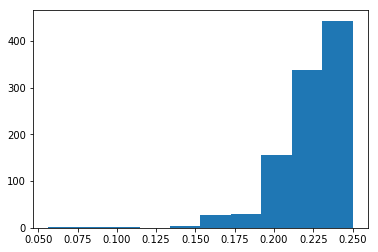

11 num approx zero 2


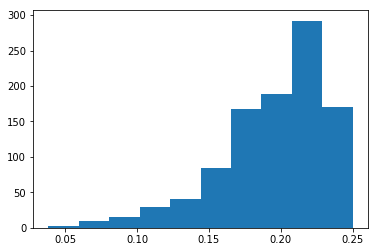

12 num approx zero 33


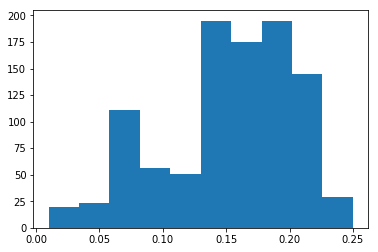

13 num approx zero 267


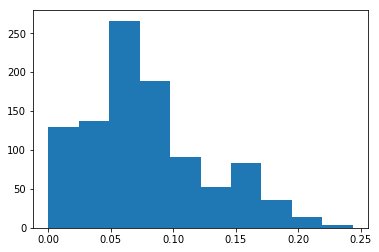

14 num approx zero 75


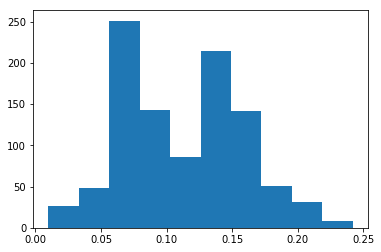

15 num approx zero 0


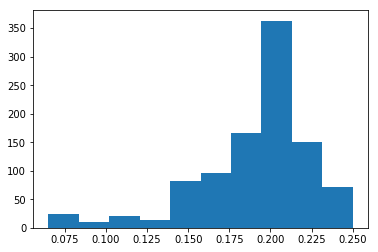

16 num approx zero 67


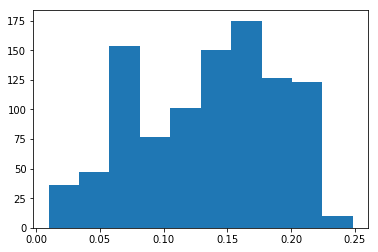

17 num approx zero 8


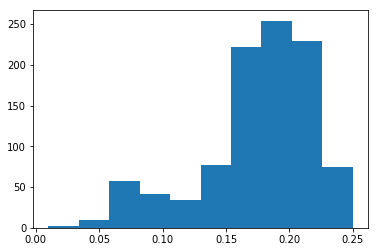

18 num approx zero 837


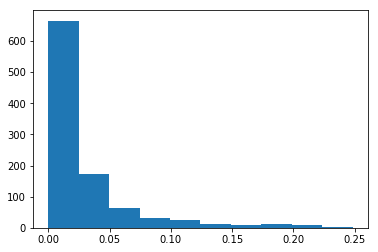

19 num approx zero 882


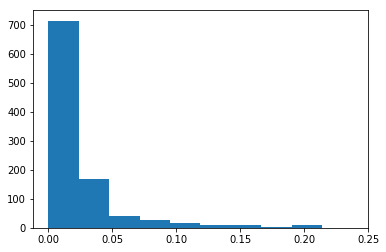

20 num approx zero 737


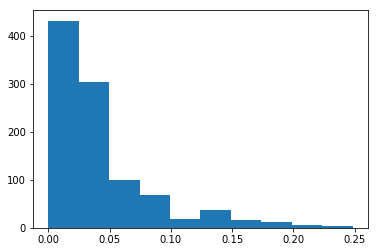

21 num approx zero 0


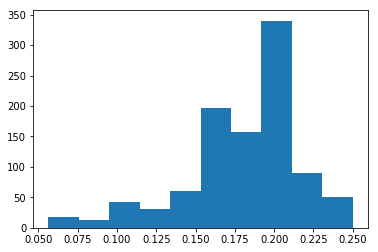

22 num approx zero 2


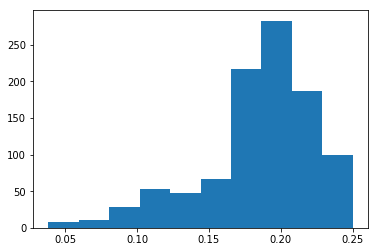

23 num approx zero 8


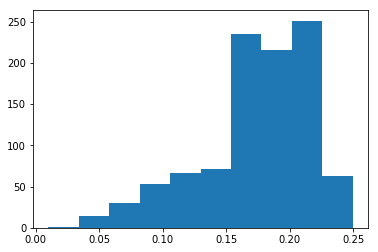

24 num approx zero 0


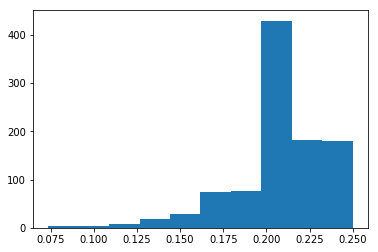

25 num approx zero 0


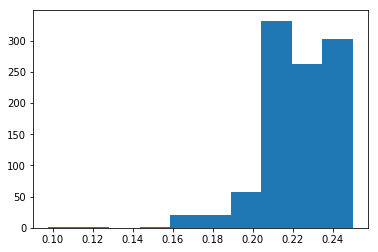

26 num approx zero 0


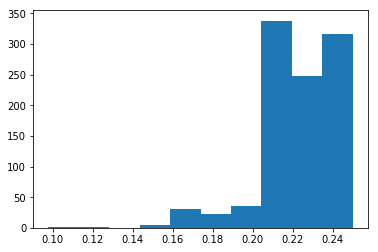

27 num approx zero 0


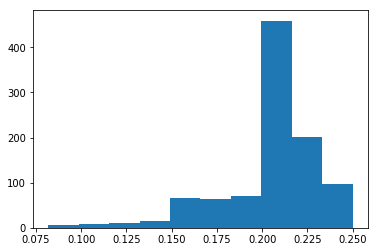

28 num approx zero 0


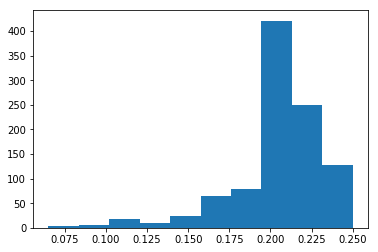

29 num approx zero 1


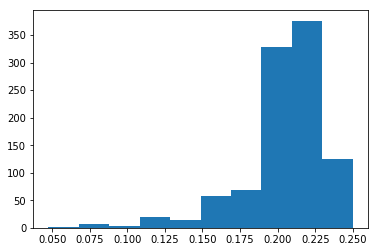

30 num approx zero 0


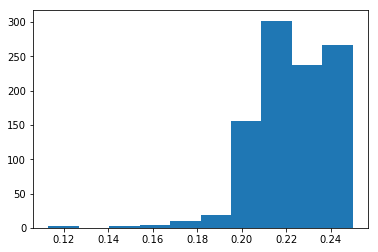

31 num approx zero 0


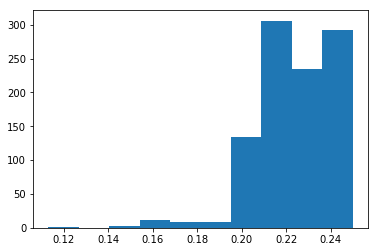

32 num approx zero 0


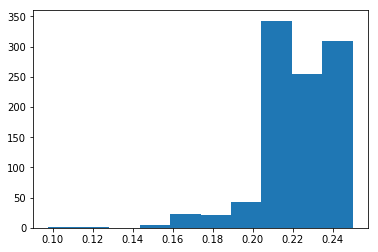

33 num approx zero 0


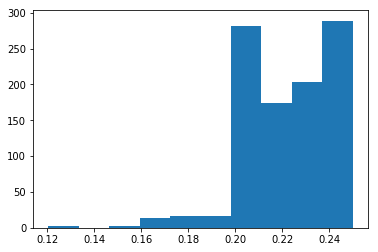

34 num approx zero 0


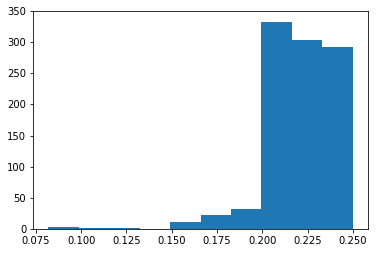

35 num approx zero 0


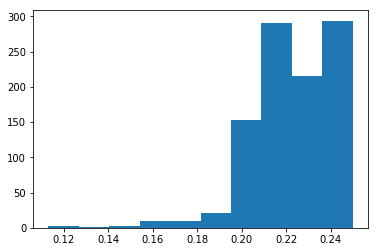

36 num approx zero 0


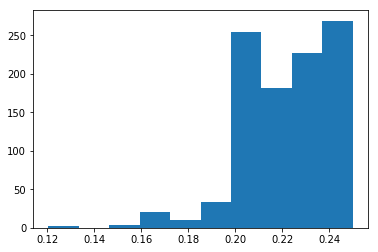

37 num approx zero 0


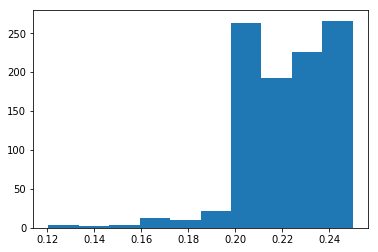

38 num approx zero 0


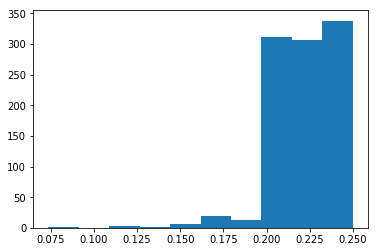

39 num approx zero 0


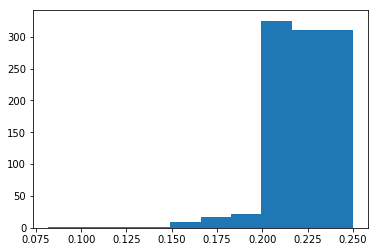

In [34]:
npzfile = np.load(fnames[0])
T_xs = npzfile['T_xs']
print(T_xs.shape)
for i in range(40):
    T_x_i = T_xs[i,:,0]
    print(i, 'num approx zero', np.sum(T_x_i < 0.05))
    plt.figure()
    plt.hist(T_xs[i,:,0])
    plt.show()

In [18]:
class sc_circuit():
    def __init__(self,):
        # time course for task
        self.t_cue_delay = 1.2
        self.t_choice = 0.6
        t_total = self.t_cue_delay + self.t_choice
        self.dt = 0.024
        self.t = np.arange(0.0, t_total, self.dt)
        self.T = self.t.shape[0]


    def simulate(self, W, Evals, w):
        # declare params
        dt = 0.024
        theta = 0.05
        beta = 0.5
        tau = 0.09
        sigma = 0.3
        
        # make inputs
        E_constant, E_Pbias, E_Prule, E_Arule, E_choice, E_light = Evals

        I_constant = np.tile(E_constant*np.array([[1, 1, 1, 1]]), (self.T, 1))

        I_Pbias = np.zeros((self.T,4))
        I_Pbias[self.t < 1.2] = E_Pbias*np.array([1, 0, 0, 1])

        I_Prule = np.zeros((self.T,4))
        I_Prule[self.t < 1.2] = E_Prule*np.array([1, 0, 0, 1])

        I_Arule = np.zeros((self.T,4))
        I_Arule[self.t < 1.2] = E_Arule*np.array([0, 1, 1, 0])

        I_choice = np.zeros((self.T,4))
        I_choice[self.t > 1.2] = E_choice*np.array([1, 1, 1, 1])

        I_lightL = np.zeros((self.T,4))
        I_lightL[self.t > 1.2] = E_light*np.array([1, 1, 0, 0])

        I_lightR = np.zeros((self.T,4))
        I_lightR[self.t > 1.2] = E_light*np.array([0, 0, 1, 1])

        I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL

        u = np.zeros((self.T, 4))
        v = np.zeros((self.T, 4))

        # initialization
        v0 = np.array([0.1, 0.1, 0.1, 0.1])
        u0 = beta*np.arctanh(2*v0 - 1) - theta

        v[0] = v0
        u[0] = u0
        for i in range(1,self.T):
            du = (dt/tau) * (-u[i-1] + np.dot(W, v[i-1]) + I_LP[i] + sigma*w[i])
            u[i] = u[i-1]+du
            v[i] = 0.5*np.tanh((u[i] - theta)/beta) + 0.5

        return v

Z = Zs[0]
T_x = T_xs[0]
M = Z.shape[0]
sW = Z[:,0]
vW = Z[:,1]
dW = Z[:,2]
hW = Z[:,3]

W = np.array([[sW, vW, dW, hW], 
              [vW, sW, hW, dW], 
              [dW, hW, sW, vW], 
              [hW, dW, vW, sW]])
W = np.transpose(W, [2, 0, 1])

E_constant = 0.0
E_Pbias = 0.1
E_Prule = 0.5
E_Arule = 0.5
E_choice = -0.2
E_light = 0.1

Es = [E_constant, E_Pbias, E_Prule, E_Arule, E_choice, E_light]

T = 75
N = 100


In [21]:
print(system.w.shape)

(75, 1, 1, 4, 100)


In [22]:
v_t = np.zeros((T, M, N, 4))
sys = sc_circuit()

for i in range(M):
    print(i)
    for j in range(N):
        v_t[:,i,j,:] = sys.simulate(W[i], Es, system.w[:,0,0,:,j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
print(v_t.shape)

(75, 1000, 100, 4)


[9.900e-03 9.801e-05]


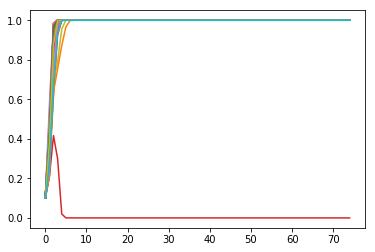

[9.900e-03 9.801e-05]


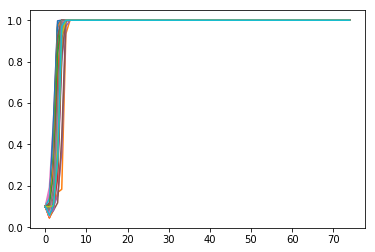

[4.78098178e-03 2.28577868e-05]


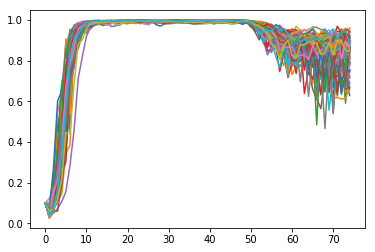

[0. 0.]


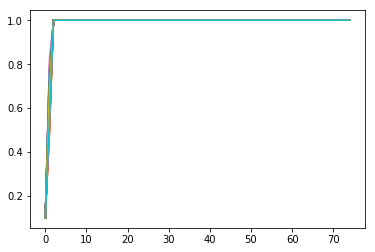

[1.45807807e-04 2.12599165e-08]


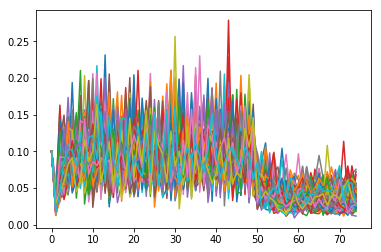

[2.18263517e-03 4.76389629e-06]


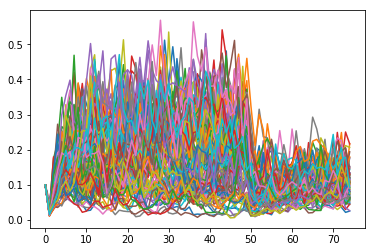

[0. 0.]


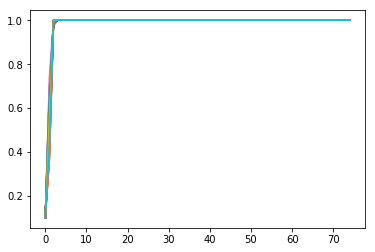

[0.0736     0.00541696]


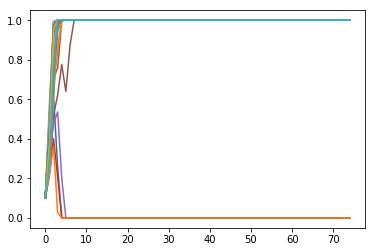

[0.2499     0.06245001]


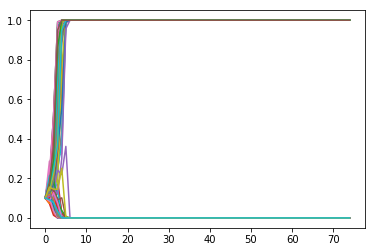

[0. 0.]


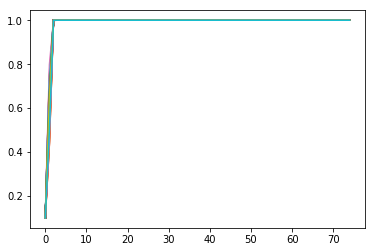

[0.1971     0.03884841]


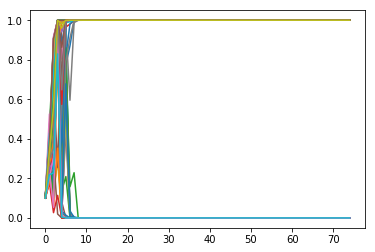

[1.25207017e-30 1.56767971e-60]


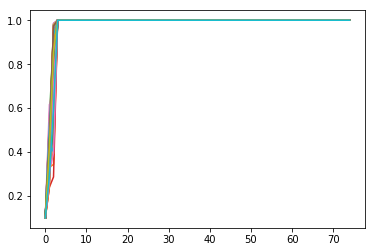

[9.89999997e-03 9.80099993e-05]


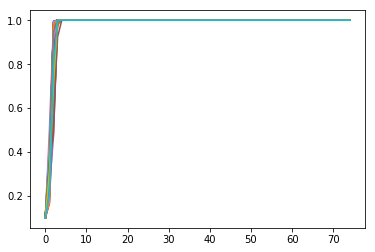

[9.900e-03 9.801e-05]


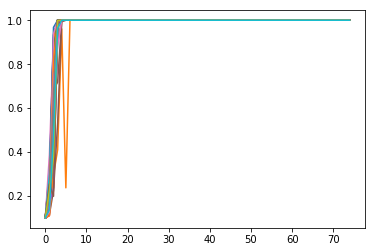

[9.900e-03 9.801e-05]


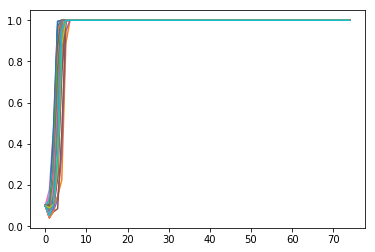

[4.91530561e-04 2.41602292e-07]


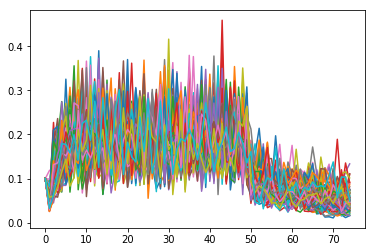

[0.15983384 0.02554686]


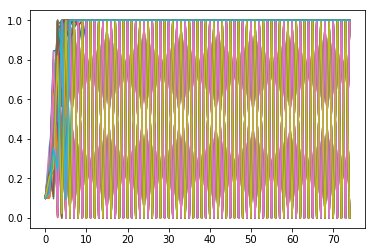

[0. 0.]


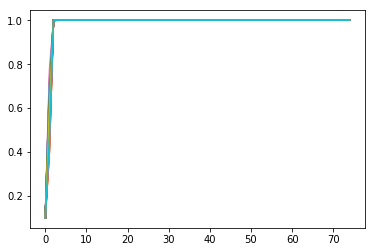

[0.24891618 0.06195927]


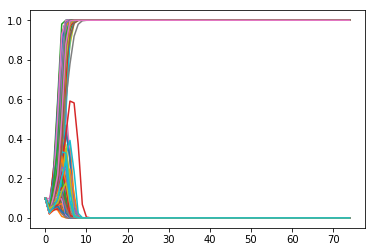

[0. 0.]


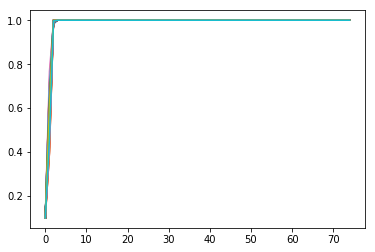

[0. 0.]


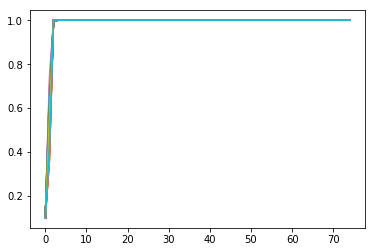

[0. 0.]


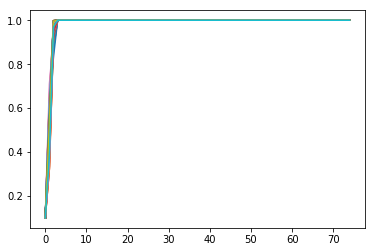

[0. 0.]


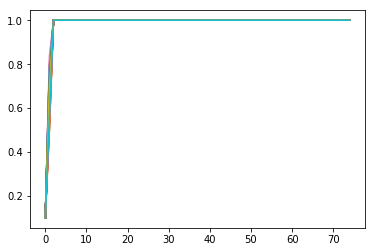

[0. 0.]


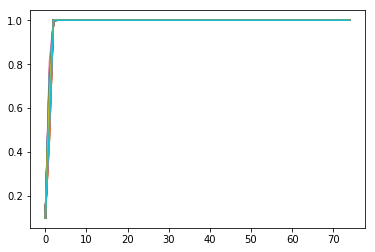

[1.47764623e-04 2.18343839e-08]


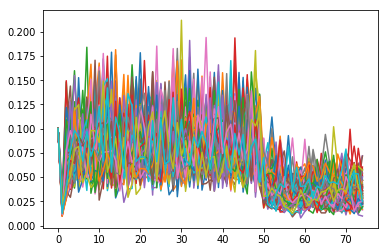

[0.2499     0.06245001]


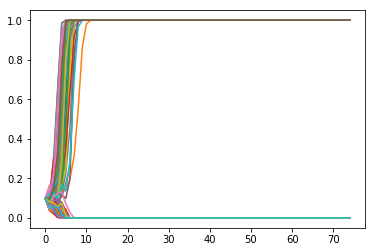

[0. 0.]


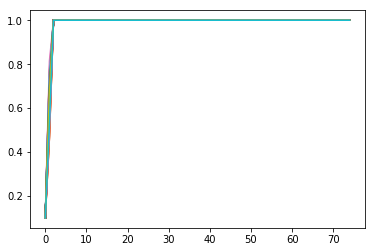

[0. 0.]


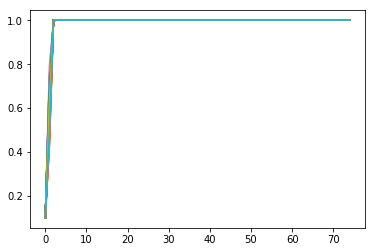

[1.28877135e-25 1.66093159e-50]


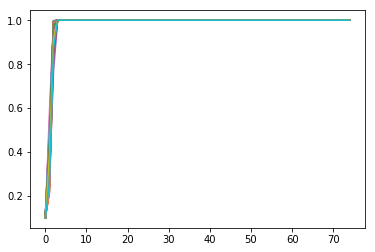

[1.35681868e-03 1.84095693e-06]


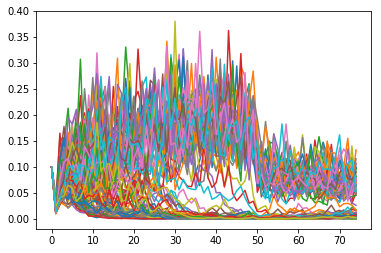

[4.75621240e-04 2.26215564e-07]


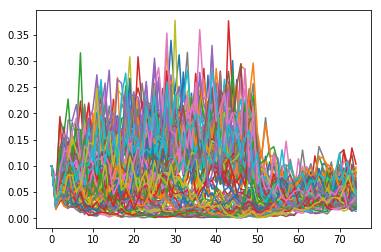

[0.22992467 0.05286535]


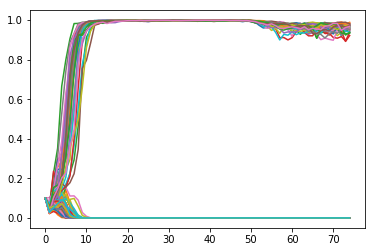

[2.59141791e-03 6.71544679e-06]


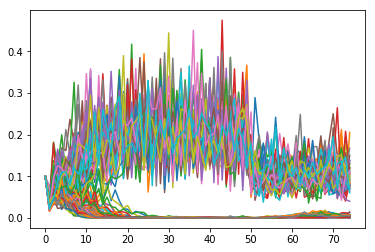

[8.09186445e-03 6.54782703e-05]


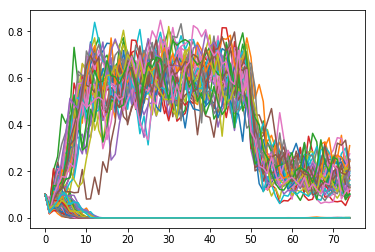

[0.24748826 0.06125044]


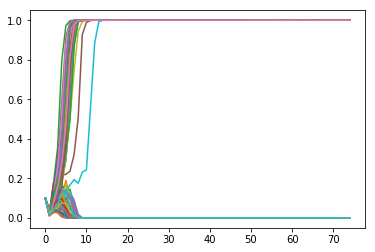

[9.90000000e-03 9.80099999e-05]


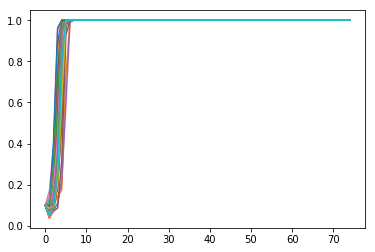

[9.89999958e-03 9.80099917e-05]


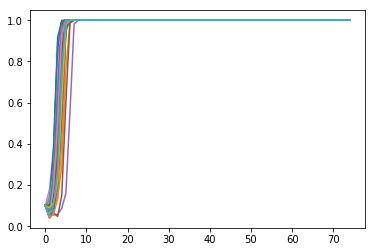

[0. 0.]


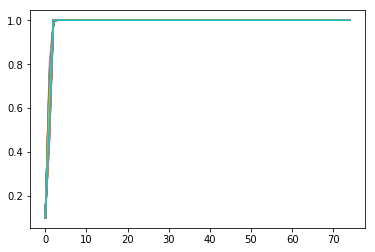

[0. 0.]


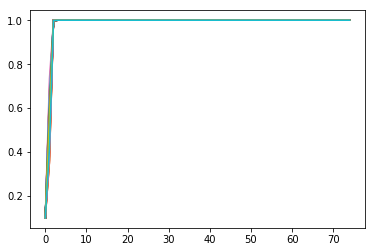

[0. 0.]


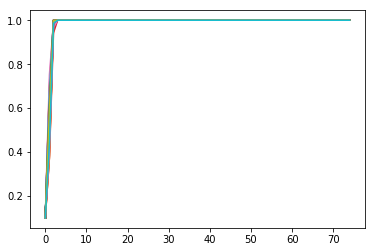

[0.0196     0.00038416]


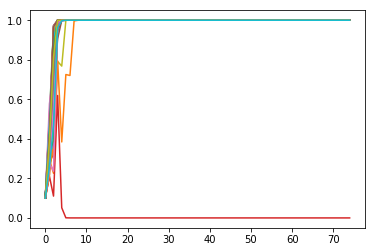

[0. 0.]


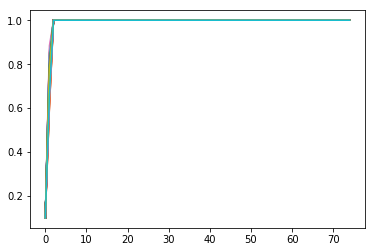

[0.1875     0.03515625]


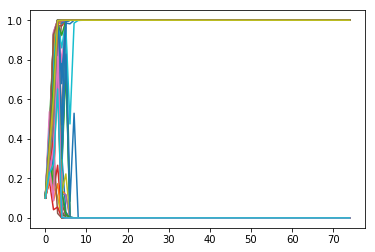

[0. 0.]


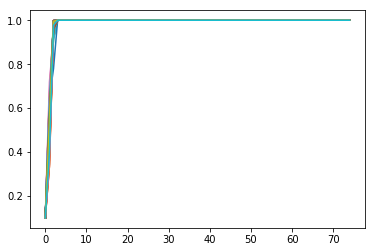

[0. 0.]


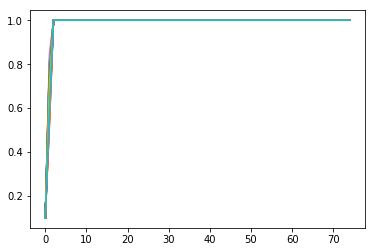

[0.24989998 0.06245   ]


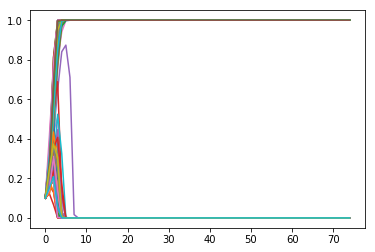

[0.2499     0.06245001]


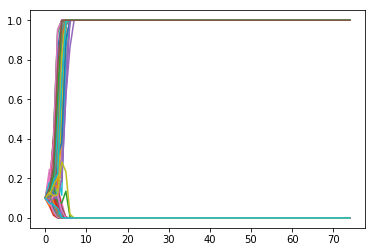

[0.03339111 0.00111497]


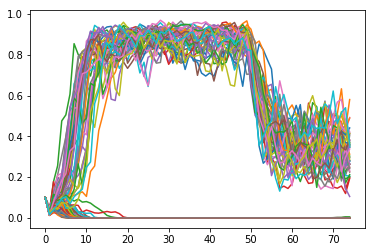

[9.900e-03 9.801e-05]


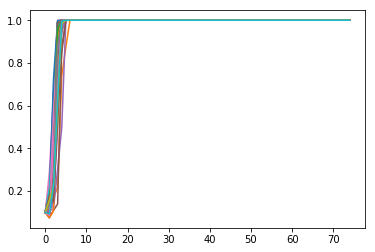

[0.23898693 0.05711475]


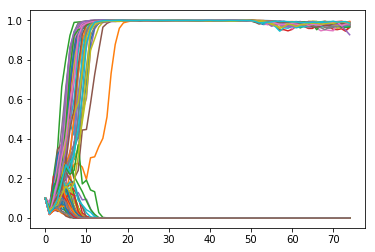

[0. 0.]


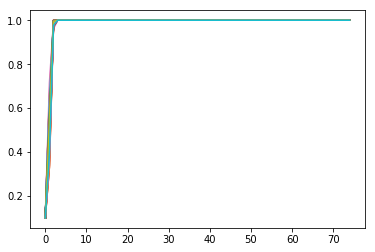

[0. 0.]


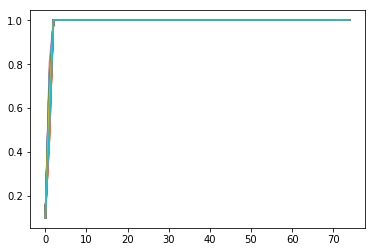

[0. 0.]


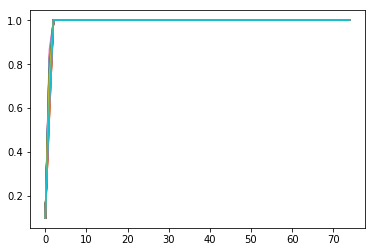

[0. 0.]


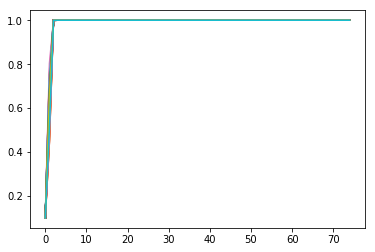

[0. 0.]


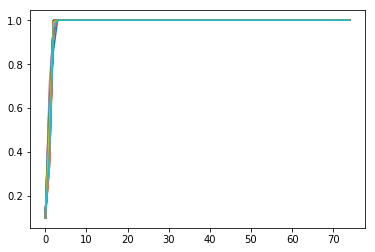

[0. 0.]


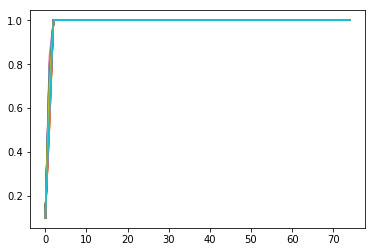

[6.14736110e-04 3.77900485e-07]


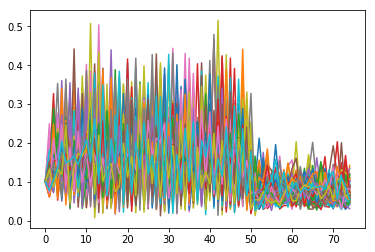

[0. 0.]


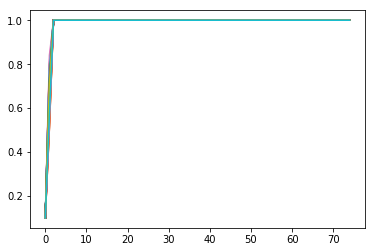

[4.80145120e-30 2.30539337e-59]


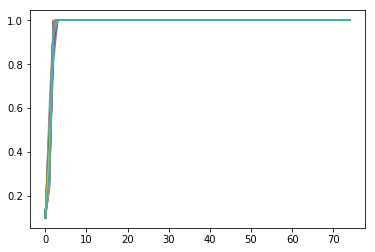

[4.31837825e-04 1.86483907e-07]


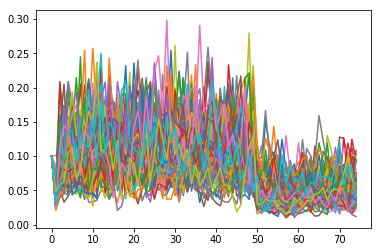

[0. 0.]


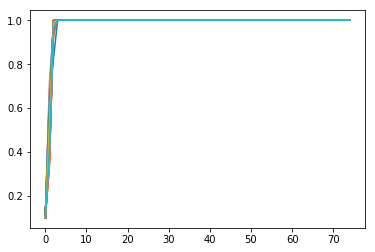

[6.98933959e-04 4.88508680e-07]


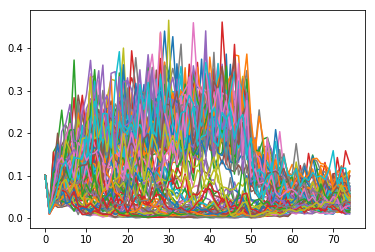

[1.63100171e-20 2.66016659e-40]


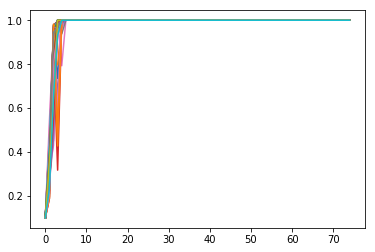

[1.63277401e-03 2.66595097e-06]


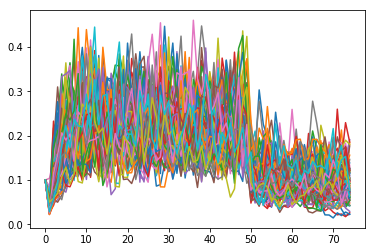

[0.12031383 0.01447542]


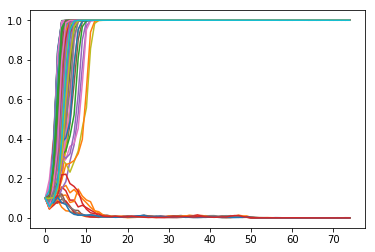

[0. 0.]


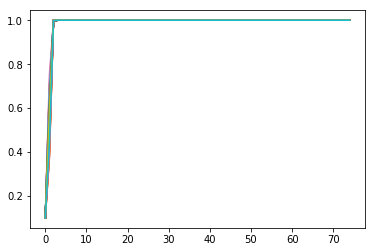

[0.24909946 0.06205054]


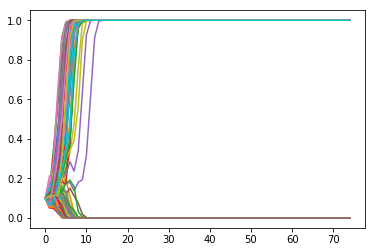

[0. 0.]


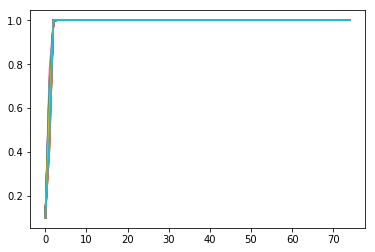

[0. 0.]


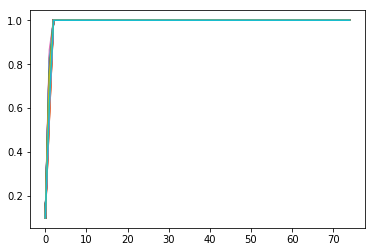

[0. 0.]


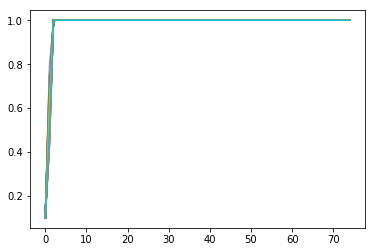

[9.900e-03 9.801e-05]


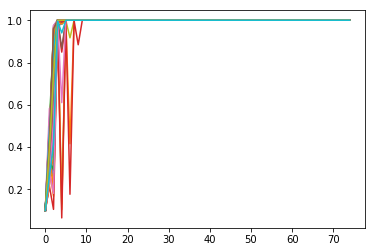

[0. 0.]


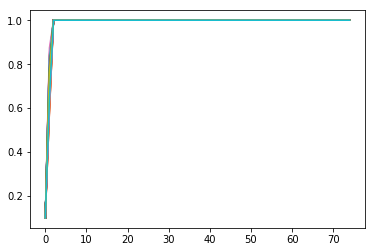

[4.28044357e-03 1.83221972e-05]


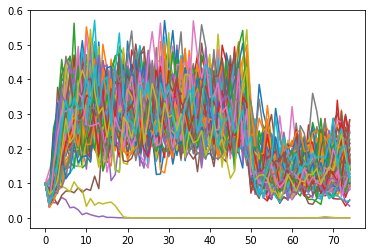

[0. 0.]


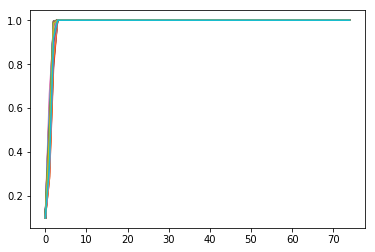

[0. 0.]


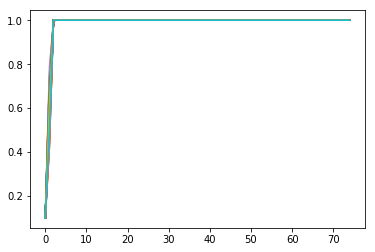

[0.2499     0.06245001]


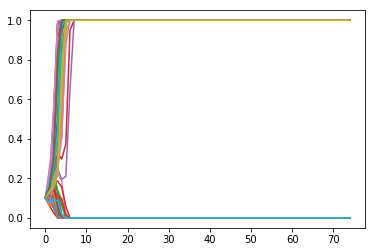

[0.2499     0.06245001]


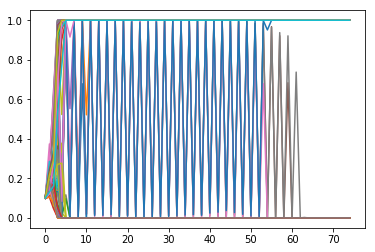

[0.01105049 0.00012211]


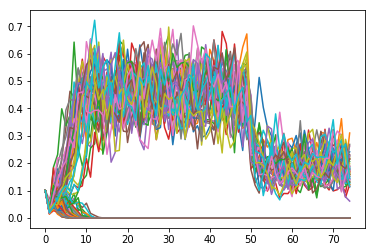

[9.90000000e-03 9.80099999e-05]


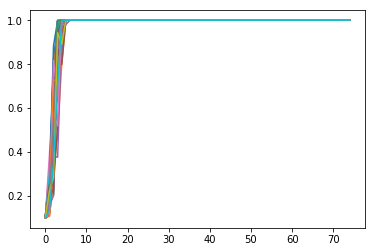

[1.69686275e-04 2.87934319e-08]


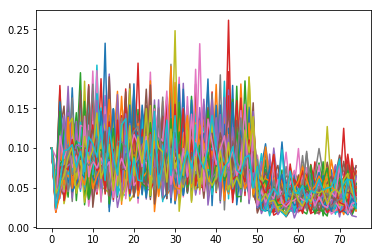

[0. 0.]


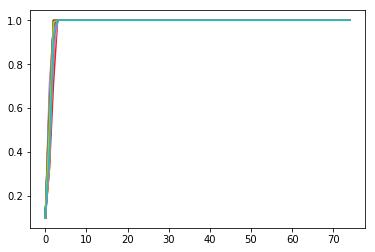

[9.900e-03 9.801e-05]


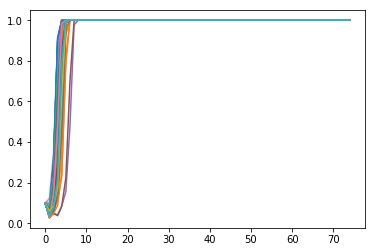

[9.900e-03 9.801e-05]


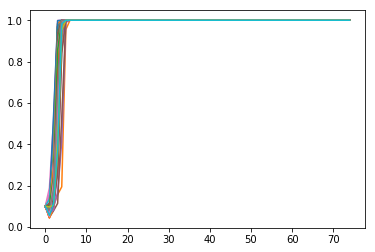

[1.85312816e-03 3.43408396e-06]


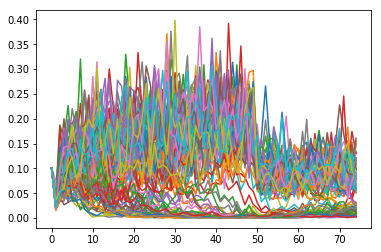

[0.2496     0.06230016]


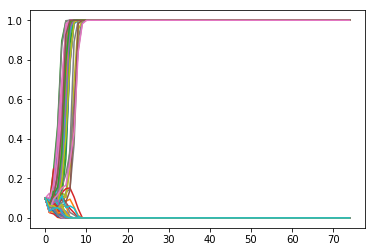

[0. 0.]


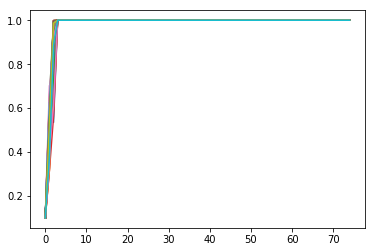

[0.24851698 0.06176069]


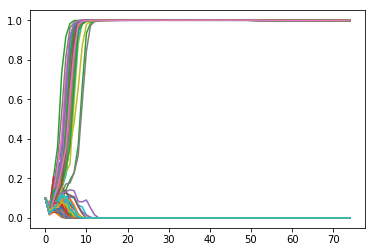

[0.2016     0.04064256]


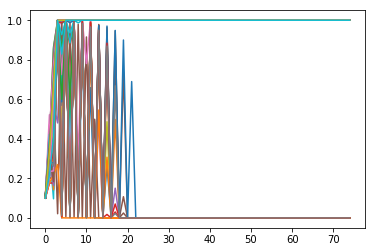

[0. 0.]


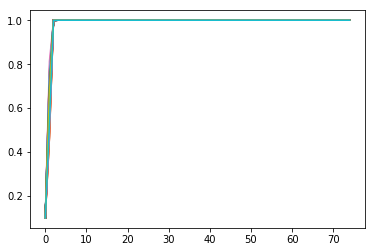

[0. 0.]


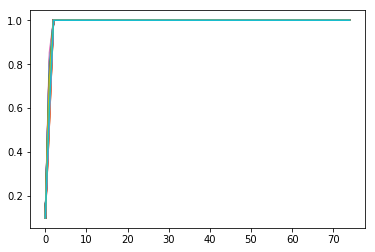

[0. 0.]


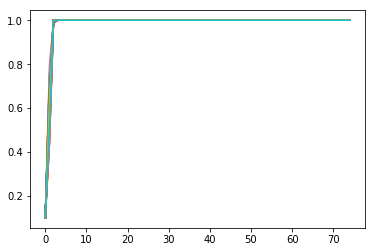

[0.24492584 0.05998867]


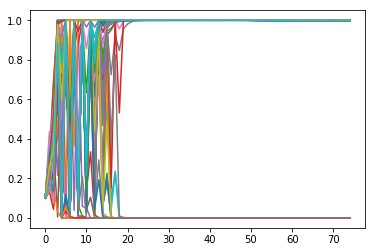

[0.2378987  0.05659579]


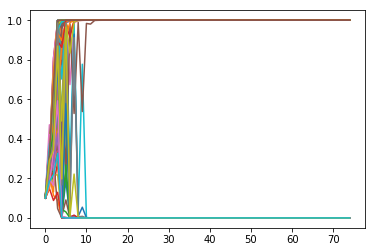

[0.2499     0.06245001]


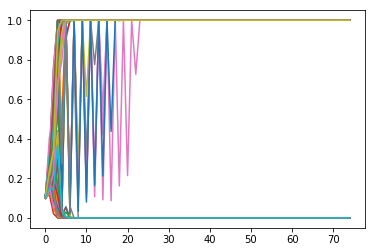

[0. 0.]


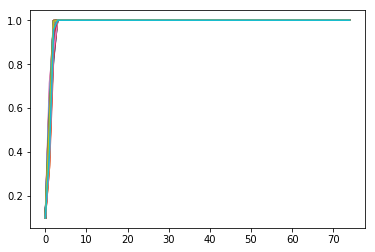

[9.89999999e-03 9.80099999e-05]


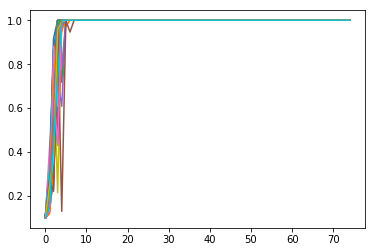

[6.16297582e-34 3.79822710e-67]


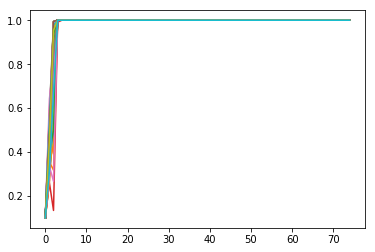

[8.28879462e-18 6.87041163e-35]


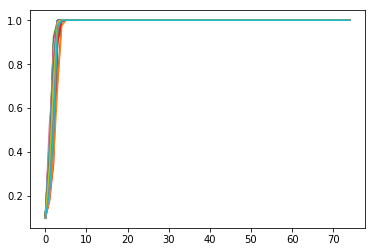

[0. 0.]


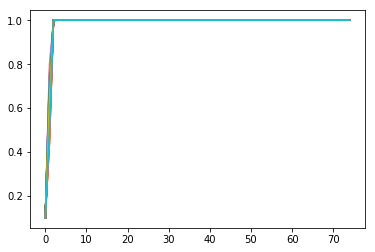

[0. 0.]


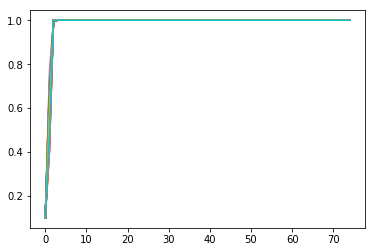

In [24]:
for i in range(100):
    plt.figure()
    print(T_x[i])
    plt.plot(v_t[:,i,:,0])
    plt.show()